# Exact GP Regression on Classification Labels: A 2D Example

For dataset size < 10,000, ExactGP works fine.

"In GPyTorch, Exact GP inference is still our preferred approach to large regression datasets. By coupling GPU acceleration with BlackBox Matrix-Matrix Inference and LancZos Variance Estimates (LOVE), GPyTorch can perform inference on datasets with over 1,000,000 data points while making very few approximations."
--[GPyTorch docs](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/index.html)

Sources:
https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html

Paper:
https://proceedings.neurips.cc/paper_files/paper/2018/file/b6617980ce90f637e68c3ebe8b9be745-Paper.pdf




In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.seed=0

/tmp/ipykernel_2661/140972768.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Generate data for training and test sets 
 
$f(x1,x2) = \sin(0.15\pi u + (x1+x2))+1, \text{where } u \sim \text{Unif}(0,1).$

$ y = \text{round}((f(x1,x2)).$


In [2]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)
    
    # 2D data
    x1 = torch.randn(num_data,1)
    x2 = torch.randn(num_data,1)

    u = torch.rand(1)
    
    # Define response as a function of x1 and x2
    data_fn = lambda x1, x2: 1 * torch.sin(0.15 * u * 3.1415 * (x1 + x2)) + 1
    latent_fn = data_fn(x1, x2)
    
    # Response
    z = torch.round(latent_fn).long().squeeze()
    
    return torch.cat((x1,x2),dim=1), z, data_fn


In [3]:
train_x, train_y, genfn = gen_data(500)

# Save to file
#df = pd.DataFrame(train_x, columns=["x1","x2"])
#df["response"] = train_y
#df

In [4]:
#df.to_csv("/p/lustre2/fan4/myGPyTorch/data/classification3_train.csv", index=0)

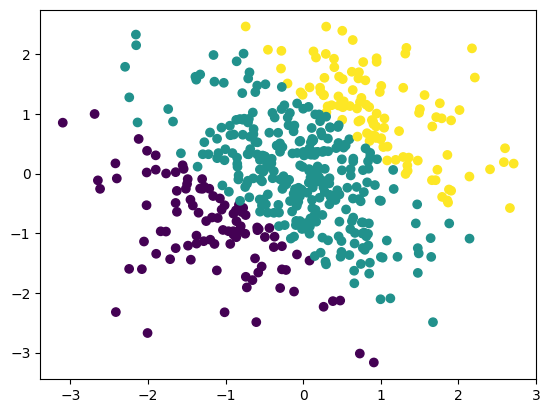

In [5]:
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

In [6]:
y=train_y.numpy()
print(np.unique(y))

[0 1 2]


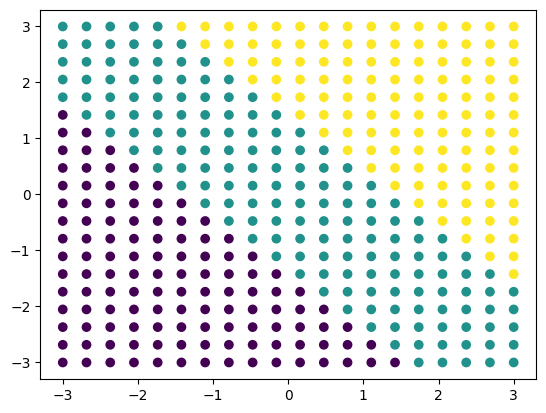

In [7]:
# Decision boundary and test sets
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_d1_mat, test_d2_mat = np.meshgrid(test_d1, test_d2)

# Convert to torch tensor
test_d1_mat, test_d2_mat = torch.Tensor(test_d1_mat), torch.Tensor(test_d2_mat)
test_x = torch.cat((test_d1_mat.view(-1,1), test_d2_mat.view(-1,1)),dim=1)


# Obtain response label
test_labels = torch.round(genfn(test_d1_mat,test_d2_mat))
test_y = test_labels.view(-1)
#print(test_labels)
#print(test_y)

plt.scatter(test_d1_mat, test_d2_mat, c = test_y)

In [8]:
# Test data
# Save to file
#test_df = pd.DataFrame(test_x, columns=["x1","x2"])
#test_df["response"] = test_y
#test_df

In [9]:
#test_df.to_csv("/p/lustre2/fan4/myGPyTorch/data/classification3_test.csv", index=0)

In [10]:
#test_df = pd.read_csv("/p/lustre2/fan4/myGPyTorch/data/classification3_test.csv",dtype="float32")
#test_x_temp = test_df.drop(columns=["response"]).to_numpy()
#test_y_temp = test_df["response"].to_numpy().astype("long")

# Torch tensor requires "long" type
#test_x = torch.from_numpy(test_x_temp)
#test_y = torch.from_numpy(test_y_temp)


#test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
#test_labels = torch.round(genfn(test_x_mat, test_y_mat))
#test_y = test_labels.view(-1)

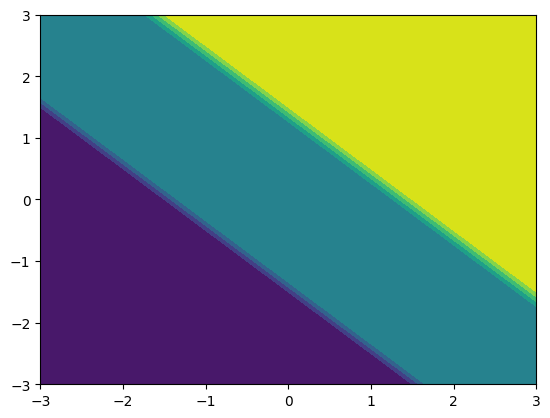

In [11]:
plt.contourf(test_d1_mat.numpy(), test_d2_mat.numpy(), test_labels.numpy())

## Setting up the Model

The Dirichlet GP model is an exact GP model with a couple of caveats. 
1. First, it uses a special likelihood: a DirichletClassificationLikelihood, and 
2. second, it is natively a multi-output model (for each data point, we need to predict `num_classes`, $C$, outputs) so we need to specify the batch shape for our mean and covariance functions.

The DirichletClassificationLikelhood is just a special type of `FixedGaussianNoiseLikelihood` that does the required data transformations into a regression problem for us. Succinctly, we soft one hot encode the labels into $C$ outputs so that $\alpha_i=\alpha_{\epsilon}$ if $y_c=0$ and $\alpha_i=1+\alpha_{\epsilon}$ if $y_c=1$ Then, our variances are $\sigma^2=\log(1./\alpha+1.)$ and our targets are $\log(\alpha)-0.5\sigma^2$. 

That is, rather than a classification problem, we have a regression problem with outputs. For more details, please see the original paper.



In [12]:
# Construct a GP classification model

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


In [13]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 6.431   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 5.934   lengthscale: 0.939   noise: 0.475
Iter 11/50 - Loss: 5.749   lengthscale: 1.056   noise: 0.322
Iter 16/50 - Loss: 5.591   lengthscale: 1.014   noise: 0.220
Iter 21/50 - Loss: 5.484   lengthscale: 0.906   noise: 0.153
Iter 26/50 - Loss: 5.391   lengthscale: 0.803   noise: 0.109
Iter 31/50 - Loss: 5.320   lengthscale: 0.722   noise: 0.080
Iter 36/50 - Loss: 5.282   lengthscale: 0.669   noise: 0.060
Iter 41/50 - Loss: 5.258   lengthscale: 0.632   noise: 0.047
Iter 46/50 - Loss: 5.237   lengthscale: 0.614   noise: 0.037


## Model Predictions

In [14]:
# Make predictions with the model

model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)
    pred_means = test_dist.loc
    
    # Obtain variance
    observed_pred = likelihood(model(test_x))

# The model gives multi-output predictions
print("Predicting the logits for each class in the classification problem.")
print(pred_means.numpy().shape)
print(pred_means)

#------------------------------------------
# Convert predictions to response labels
#------------------------------------------
# Compute the elementwise maximum at each test point
# Taking maxinum values at the first axis (.max(0)).
# Take the maximun indices as the response labels [1].
print(pred_means.max(0)[1])

Predicting the logits for each class in the classification problem.
(3, 400)
tensor([[-2.3184, -1.8866, -1.5017,  ..., -3.6426, -3.4684, -3.3050],
        [-3.9192, -4.2981, -4.6728,  ..., -3.8278, -3.7173, -3.6241],
        [-3.8335, -4.2348, -4.5795,  ..., -2.5206, -2.7329, -2.9180]])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2

In [15]:
#------------------------------------------
# Convert predictions to response labels
#------------------------------------------
test_prediction = model(test_x).loc.max(0)[1].numpy()
print(test_prediction.shape)
test_prediction

(400,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,

We’ve predicted the logits for each class in the classification problem, and can clearly see that 
1. the logits for class 0 are highest in the bottom left, 
2. the logits for class 2 are highest in the top right, and 
3. the logits for class 1 are highest in the middle.

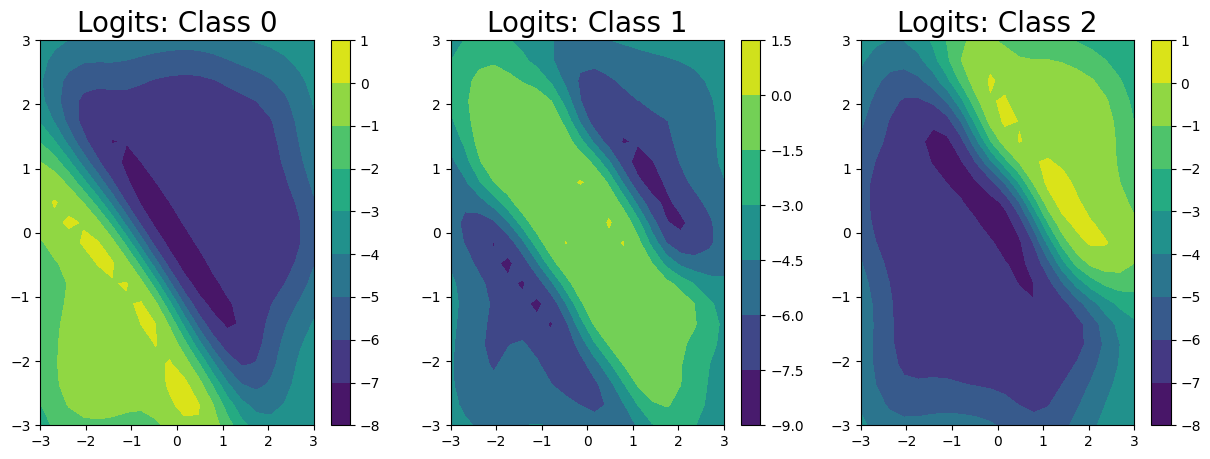

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_d1_mat.numpy(), test_d2_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)



Unfortunately, we can’t get closed form estimates of the probabilities; however, we can approximate them with a lightweight sampling step using $J$ samples from the posterior as:


$\displaystyle\mathbb{E}(p(y_i=j)) = \int \frac{\exp\{f_i^*\}}{\sum_k^C\exp\{f_i^*\}}p(f^*\|y)df^* \approx \frac{1}{J}\sum_j^J\frac{\exp\{f_{i,j}^*\}}{\sum_k^C\exp\{f_{i,j}^*\}}$. 

Here, we draw __256__ samples from the posterior.



In [17]:
# Draw samples from the posterior.
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

/global/scratch/users/fan4/gpytorch-venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/global/scratch/users/fan4/gpytorch-venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


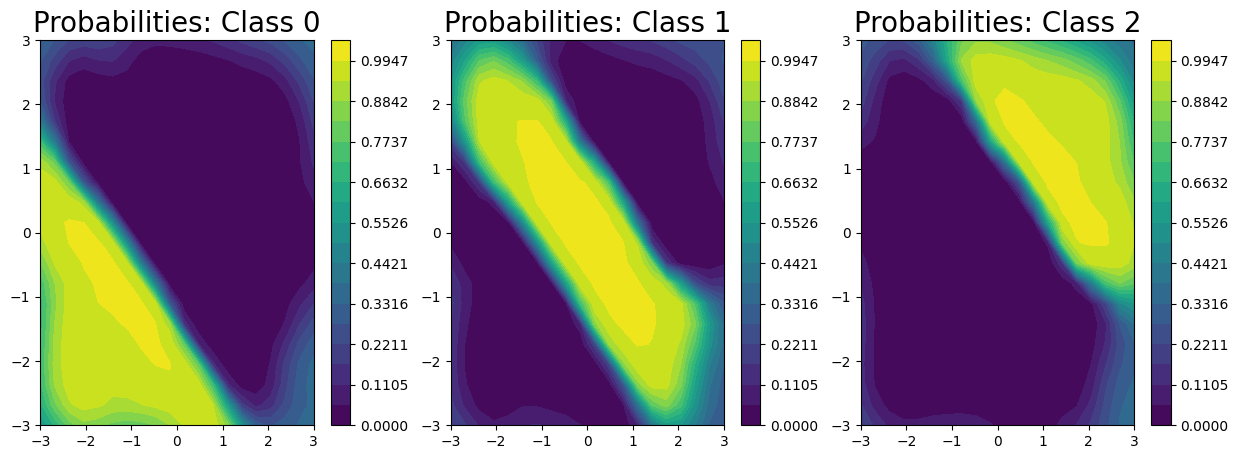

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_d1_mat.numpy(), test_d2_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Finally, we plot the decision boundary (on the right) and the true decision boundary on the left. They align pretty closely.

To get the decision boundary from our model, all we need to do is to compute the elementwise maximium at each test point.

Text(0.5, 1.0, 'Estimated Response')

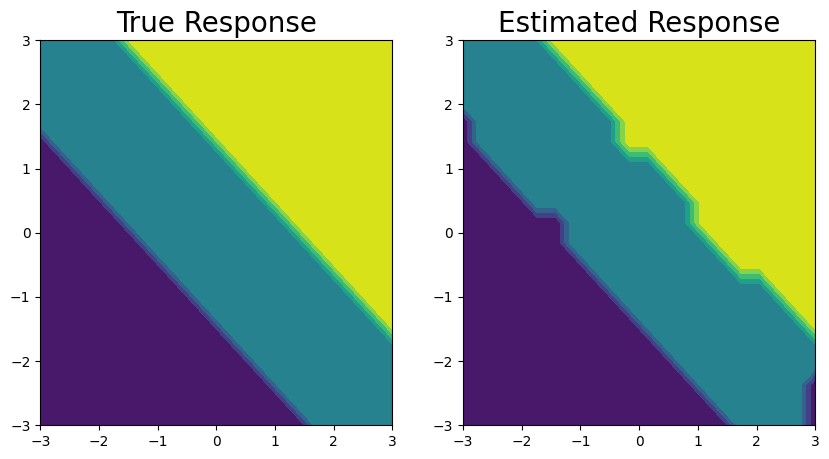

In [19]:
# Decision boundary
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_d1_mat.numpy(), test_d2_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_d1_mat.numpy(), test_d2_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)

## Variances (Uncertainties)

In [20]:
lower, upper = observed_pred.confidence_region()
upper

tensor([[ 0.8530,  0.9512,  0.8908,  ..., -0.3013, -0.0840,  0.1170],
        [-0.3201, -0.8245, -1.4301,  ..., -0.2175, -0.0864,  0.0198],
        [-0.5203, -1.0993, -1.6589,  ...,  0.6819,  0.5641,  0.4679]])

In [21]:
print(observed_pred.variance.numpy().shape)
observed_pred.variance.numpy()

(3, 400)


array([[2.51449  , 2.0133495, 1.4310203, ..., 2.7910347, 2.8636107,
        2.92752  ],
       [3.2383347, 3.016468 , 2.6287634, ..., 3.258693 , 3.2958107,
        3.3195508],
       [2.7443523, 2.4579282, 2.1324697, ..., 2.5639985, 2.7175636,
        2.8661203]], dtype=float32)

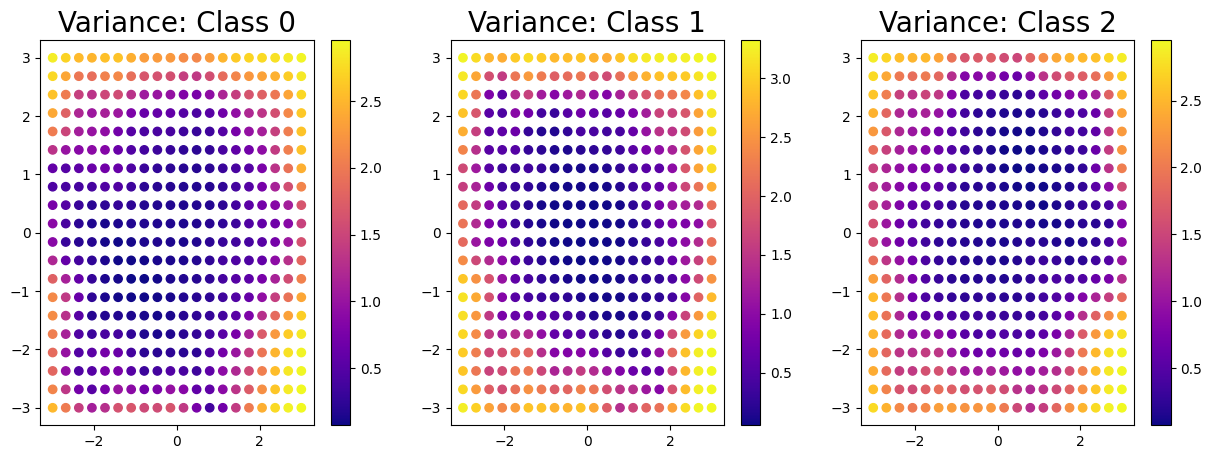

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    im = ax[i].scatter(
        test_d1_mat.numpy(), test_d2_mat.numpy(), c=observed_pred.variance.numpy()[i].reshape((20,20)), cmap='plasma'
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Variance: Class " + str(i), fontsize = 20)



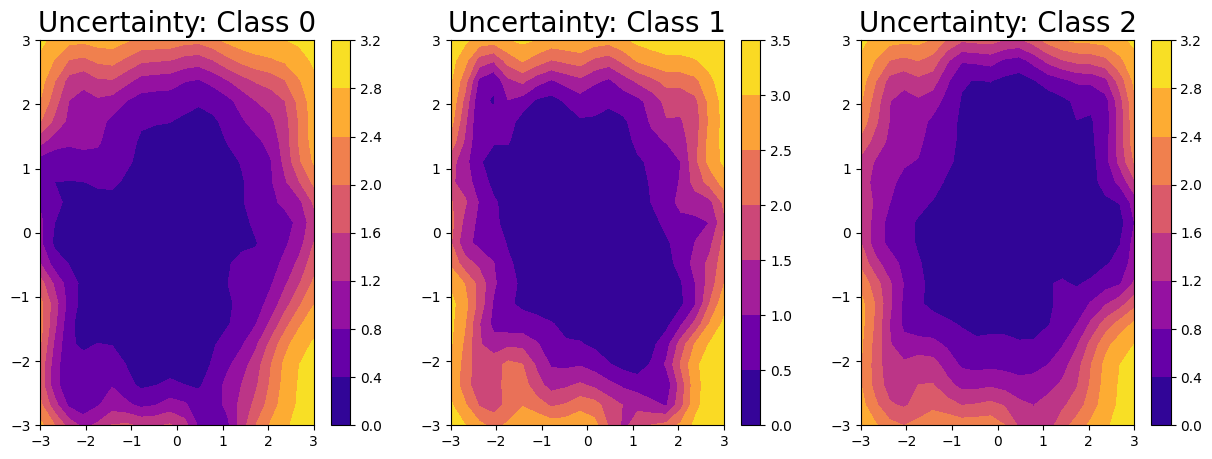

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i in range(3):
    im = ax[i].contourf(
        test_d1_mat.numpy(), test_d2_mat.numpy(), observed_pred.variance.numpy()[i].reshape((20,20)), cmap='plasma',
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Uncertainty: Class " + str(i), fontsize = 20)

